<a href="https://colab.research.google.com/github/fabriziobasso/kaggle/blob/main/Optiver_comp_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OPTIVER COMPETITION SEPT-2023**

## **1.0 Dataset Description**
This dataset contains historic data for the daily ten minute closing auction on the NASDAQ stock exchange. Your challenge is to predict the future price movements of stocks relative to the price future price movement of a synthetic index composed of NASDAQ-listed stocks.

This is a forecasting competition using the time series API. The private leaderboard will be determined using real market data gathered after the submission period closes.

#### **Files**
* **[train/test].csv** The auction data. The test data will be delivered by the API.

* **stock_id** - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
* **date_id** - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
* **imbalance_size** - The amount unmatched at the current reference price (in USD).
* **imbalance_buy_sell_flag** - An indicator reflecting the direction of auction imbalance:
  * buy-side imbalance; 1
  * sell-side imbalance; -1
  * no imbalance; 0
* **reference_price** - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
* **matched_size** - The amount that can be matched at the current reference price (in USD).
* **far_price** - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
* **near_price** - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
* **[bid/ask]_price** - Price of the most competitive buy/sell level in the non-auction book.
* **[bid/ask]_size** - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
* **wap** - The weighted average price in the non-auction book.

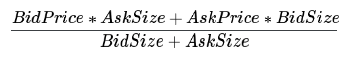

* **seconds_in_bucket** - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
* **target** - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
 * The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
 * The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
 * Where t is the time at the current observation, we can define the target:

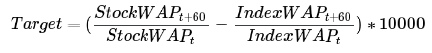

All size related columns are in USD terms.

**All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.**

* **sample_submission**: A valid sample submission, delivered by the API. See this [notebook](https://www.kaggle.com/code/sohier/optiver-2023-basic-submission-demo) for a very simple example of how to use the sample submission.

* **revealed_targets** The first time_id for each date in this file provides the true target values for the entire previous date. All other rows contain mostly null values.

* **public_timeseries_testing_util.py**: An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details.

* **example_test_files** Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API.

* **optiver2023** Files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory.

#### **Relevant Files**

* [Starter Pack v1](https://www.kaggle.com/code/mmmarchetti/the-most-simple-and-dumbest-starter-s-notebook)
* [Discussion](https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion)
* [Starter Pack v1](https://www.kaggle.com/code/iqbalsyahakbar/optiver-a-starter-s-notebook/notebook)  
* [Discord Chat](https://discord.com/channels/1101210829807956100/onboarding)

### 1.1 Install Packages:

In [1]:
%%capture
!pip install tensorflow-addons
#!pip install shap
#!pip install eli5
#!pip install tf-nightly
#!pip install -U scikit-learn==1.2.0
#!pip install catboost
#!pip install haversine
!pip install pytorch-forecasting
!pip install umap-learn
#!pip install reverse_geocoder
#!pip install --upgrade protobuf
!pip install colorama
!pip install imbalanced-learn
!pip install optuna
!pip install optuna-integration
#!pip install pygam
!pip install keras-tuner --upgrade
#!pip install pycaret
!pip install lightning==2.0.1
!pip install keras-nlp

### **1.2 Packages**

In [2]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

In [3]:
#importing modules

import warnings
warnings.filterwarnings('ignore')
import time
t = time.time()

print('Importing started...')

# basic moduele
import os
import numpy as np
import pandas as pd
import re
#from scipy import stats
from random import randint
import random
import math
import os
import gc
import pickle
from glob import glob
from IPython import display as ipd
from tqdm import tqdm
from datetime import datetime
from joblib import dump, load
import sklearn as sk
from imblearn.over_sampling import SMOTE, RandomOverSampler
from functools import partial
import itertools
from itertools import combinations
import IPython
import statsmodels.api as sm
import IPython.display

# visualization moduels
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib_venn import venn2_unweighted
import seaborn as sns
import missingno as msno
import imblearn

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
#sns.set_theme(style="ticks", context="notebook")
sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

# Style Import
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

# preprocessing modules
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     StratifiedKFold,
                                     cross_val_score,
                                     GroupKFold,
                                     GridSearchCV,
                                     RepeatedStratifiedKFold)

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder,
                                   PolynomialFeatures)

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel


# metrics
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss)


# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  TweedieRegressor,
                                  ARDRegression,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.isotonic import IsotonicRegression

from sklearn.ensemble import (AdaBoostRegressor,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              StackingRegressor,
                              HistGradientBoostingClassifier,
                              ExtraTreesClassifier)

from sklearn.base import BaseEstimator, TransformerMixin

# Other Models
#from pygam import LogisticGAM, s, te
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

#import catboost as cat
#from catboost import CatBoost, CatBoostRegressor
#from catboost import CatBoostClassifier

#from catboost.utils import get_roc_curve

from lightgbm import early_stopping
# check installed version
#import pycaret
warnings.filterwarnings("ignore")


from sklearn.base import clone ## sklearn base models for stacked ensemble model
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

#Interpretiability of the model
#import shap
#import eli5
#from eli5.sklearn import PermutationImportance


## miss
from sklearn.pipeline import (make_pipeline,
                              Pipeline)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from keras.utils import FeatureSpace
import keras_nlp

# Import libraries for Hypertuning
import kerastuner as kt
from kerastuner.tuners import RandomSearch, GridSearch, BayesianOptimization
# Model Tuning tools:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
%matplotlib inline
SEED = 1984
N_SPLITS = 10

print('Done, All the required modules are imported. Time elapsed: {} sec'.format(time.time()-t))

Importing started...
Using TensorFlow backend
Done, All the required modules are imported. Time elapsed: 5.753325700759888 sec


<Figure size 640x480 with 0 Axes>

In [4]:
# Check Versions:
print("CHECK VERSIONS:")
print(f"sns: {sns.__version__}")
print(f"mpl: {mpl.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"scikit-learn: {sk.__version__}")
print(f"statsmodels: {sm.__version__}")
print(f"missingno: {msno.__version__}")
#print(f"TF-addon: {tfa.__version__}")
print(f"Inbalance_Learning: {imblearn.__version__}")
print(f"XGBoost: {xgb.__version__}")
#print(f"CatBoost: {cat.__version__}")
#print(f"PyCaret: {pycaret.__version__}")

CHECK VERSIONS:
sns: 0.12.2
mpl: 3.7.1
tensorflow: 2.14.0
pandas: 1.5.3
numpy: 1.23.5
scikit-learn: 1.2.2
statsmodels: 0.14.0
missingno: 0.5.2
Inbalance_Learning: 0.10.1
XGBoost: 2.0.0


### **2.1 Connect Drives**

Verify System:

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
tf.random.set_seed(0)
np.random.seed(0)
random.seed(42)

SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything(SEED)

Connect to Google Drive:

In [7]:
%%capture
# Connect to Colab:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
folder_data = "/content/drive/MyDrive/kaggle/Optiver_comp_2023/Data/"
models_folders = "/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models"
folders_nn = "/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models/neural_networks/"

list_directories = [folder_data,models_folders,folders_nn]

for path in list_directories:
  try:
      os.mkdir(path)
  except OSError as error:
      print(f"{path} already exists")


os.chdir(folder_data)

/content/drive/MyDrive/kaggle/Optiver_comp_2023/Data/ already exists
/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models already exists
/content/drive/MyDrive/kaggle/Optiver_comp_2023/Models/neural_networks/ already exists


## 2.0 Utility Functions:

### 2.1 Visualization Utilities:

In [9]:
def find_parameters(df):

  X_ = df[(df["far_price"]>=0.5)|(df["far_price"]<=1.5)]["near_price"].values.reshape(-1,1)
  y_ = df[(df["far_price"]>=0.5)|(df["far_price"]<=1.5)]["far_price"].values.reshape(-1,1)
  print(X_.shape,y_.shape)
  lr = LinearRegression()

  lr.fit(X=X_,y=y_)
  print("Coeff: {}\nIntercept: {}".format(lr.coef_[0][0], lr.intercept_[0]))

  return lr.intercept_[0], lr.coef_[0][0]

def replace_farprice(df_, intercept, beta):
  df  = df_.copy()
  arr_0 = df[(df["far_price"]>1.5)|(df["far_price"]<0.5)]["far_price"].values
  arr_1 = df[(df["far_price"]>1.5)|(df["far_price"]<0.5)]["near_price"].values

  arr_1 = intercept + beta*arr_1

  df["far_price"].replace(arr_0, arr_1, inplace=True)

  arr_2_ind = df[(df["far_price"].isna()==True)&(df["near_price"].isna()==False)].index

  arr_2 = intercept + beta*df.loc[arr_2_ind,"near_price"]

  df.loc[arr_2_ind,"far_price"] = arr_2

  df["check_near_far"] = df["near_price"].div(df["far_price"])

  return df

def train_col_def(df):

  train_col = list(df.columns)
  aggregator = ["stock_id","time_id","date_id"]
  for ag in aggregator:
    train_col.remove(ag)

  return train_col

def fill_nan_df(df):

  df_ = df.copy()
  print("Dataset Original Shape: {}".format(df_.shape))
  # Replace extreme Values in near and far prices:
  alpha, beta = find_parameters(df_)
  df_ = replace_farprice(df_, intercept=alpha, beta=beta)

  values = {"far_price": df_.loc[:,"far_price"].median(), "near_price": df_.loc[:,"near_price"].median()}
  df_.fillna(value=values,inplace=True)
  df_["check_near_far"] = df_["near_price"].div(df_["far_price"])

  list_cols_fill = ["imbalance_size","imbalance_buy_sell_flag","wap","reference_price","matched_size","bid_price","ask_price","check_near_far"]

  for data in list_cols_fill:
      train_col = train_col_def(df_)
      df_reshaped = df_.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
      df_reshaped.loc[:,data].fillna(method="ffill",axis=0,inplace=True)
      df_ = df_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)

  # Create additional Features: "imbalance_size_sign"
  df_["imbalance_size_sign"] = df_["imbalance_size"].multiply(df_["imbalance_buy_sell_flag"])
  # Create additional Features:
  df_["imbalance_size_sign_delta"] = 0
  train_col = train_col_def(df_)
  df_reshaped = df_.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
  df_reshaped["imbalance_size_sign_delta"] = df_reshaped["imbalance_size_sign"].diff()
  df_reshaped["imbalance_size_sign_delta"].fillna(method="ffill",inplace=True)
  df_reshaped["imbalance_size_sign_delta"][df_reshaped[("seconds_in_bucket",0)]==0] = 0
  #Reshape in the Original Format:
  new_df_ = df_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)
  new_df_.reset_index(inplace=True, drop=True)
  print("Dataset Final Shape: {}".format(new_df_.shape))

  return new_df_

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret.iloc[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    #rsi_df = rsi_df.dropna()
    return rsi_df#[3:]

### 2.2 Model Constructions:

## 3.0 Import Data

In [10]:
train = pd.read_csv(r'train.csv').drop('row_id', axis = 1)
train = train.dropna(axis=0, subset=["target"])
revealed_targets = pd.read_csv("example_test_files/revealed_targets.csv")
test = pd.read_csv("example_test_files/test.csv")

In [11]:
train.isna().sum()/len(train)

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000025
imbalance_buy_sell_flag    0.000000
reference_price            0.000025
matched_size               0.000025
far_price                  0.552561
near_price                 0.545466
bid_price                  0.000025
bid_size                   0.000000
ask_price                  0.000025
ask_size                   0.000000
wap                        0.000025
target                     0.000000
time_id                    0.000000
dtype: float64

In [12]:
train.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
dtype: int64

In [13]:
display(train.tail(3))
revealed_targets.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454
5237979,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,-6.530285,26454


,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0,481,0,26455,-1.279712,480,26400
1,1,481,0,26455,-4.460216,480,26400
2,2,481,0,26455,5.899668,480,26400


## **4.0 Features Cleaning**

In [14]:
train_new_df = fill_nan_df(train)
train_new_df.isna().sum()

Dataset Original Shape: (5237892, 16)
(2343638, 1) (2343638, 1)
Coeff: 2.2491285714921436
Intercept: -1.2465923656098574
Dataset Final Shape: (5237892, 19)


time_id                      0
date_id                      0
stock_id                     0
seconds_in_bucket            0
imbalance_size               0
imbalance_buy_sell_flag      0
reference_price              0
matched_size                 0
far_price                    0
near_price                   0
bid_price                    0
bid_size                     0
ask_price                    0
ask_size                     0
wap                          0
target                       0
check_near_far               0
imbalance_size_sign          0
imbalance_size_sign_delta    0
dtype: int64

In [15]:
26455*3200/19

4455578.947368421

### 3.1 Far Price and Near Price
The analysis reveals that far_price and near_price start printing only after the first 5mins in the closing auciton. All the NaN are therefore replaced with the median value of 1.

In [16]:
fp = train.groupby(["stock_id","time_id","date_id"])["far_price"].agg("first").unstack("stock_id")
fp = fp.reset_index(level=1)
fp.isnull().sum().sum()

2947362

In [17]:
train.loc[:,["far_price","near_price"]].describe().T

,count,mean,std,min,25%,50%,75%,max
far_price,2343638.0,1.001713,0.721471,0.000077,0.996332,0.999883,1.003318,437.953100
near_price,2380800.0,0.999660,0.012169,0.786988,0.997100,0.999889,1.002590,1.309732


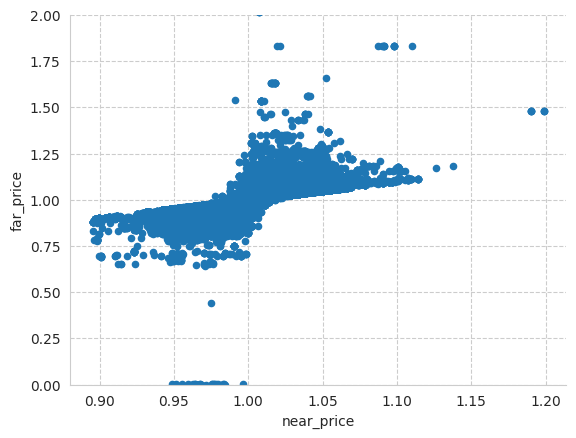

In [18]:
train.loc[:,["far_price","near_price"]].plot(kind="scatter", x="near_price",y="far_price");
#plt.xlim(left=0, right=2);
plt.ylim(bottom=0, top=2);

* **Replace extreme Values**

`Far_price` has a number of extreme values. They might be connected to wrong readings or fat-fingers. Extreme values are replaced by interpolated values from a linear regression from `near_price`



In [19]:
alpha, beta = find_parameters(train)
train = replace_farprice(train, intercept=alpha, beta=beta)

(2343638, 1) (2343638, 1)
Coeff: 2.2491285714921436
Intercept: -1.2465923656098574


In [20]:
values = {"far_price": train.loc[:,"far_price"].median(), "near_price": train.loc[:,"near_price"].median()}
train.fillna(value=values,inplace=True)

In [21]:
train.loc[:,["far_price","near_price"]].describe().T

,count,mean,std,min,25%,50%,75%,max
far_price,5237892.0,0.999849,0.016325,0.523445,0.999891,0.999891,0.999891,1.699163
near_price,5237892.0,0.999785,0.008205,0.786988,0.999889,0.999889,0.999889,1.309732


In [22]:
#lin_x = np.linspace(0,2,50)
#lin_y = alpha+beta*lin_x

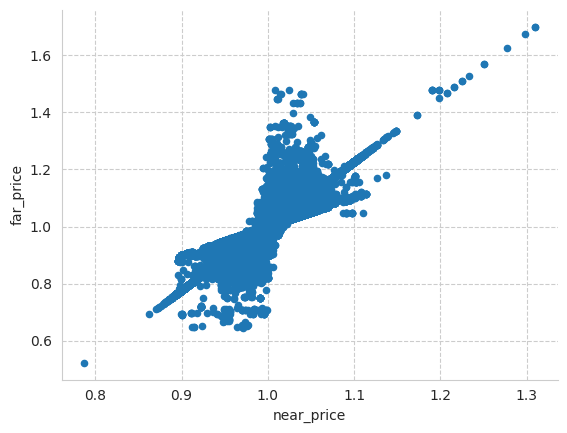

In [23]:
train.loc[:,["far_price","near_price"]].plot(kind="scatter", x="near_price",y="far_price");

#### 3.1.1 Create new Feature: "check_near_far"

In [24]:
train["check_near_far"] = train["near_price"].div(train["far_price"])
train.isna().sum()

stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             132
imbalance_buy_sell_flag      0
reference_price            132
matched_size               132
far_price                    0
near_price                   0
bid_price                  132
bid_size                     0
ask_price                  132
ask_size                     0
wap                        132
target                       0
time_id                      0
check_near_far               0
dtype: int64

### 3.2 **Imbalance_size**

In [25]:
display(train.head(5))
train_new_df.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,check_near_far
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999891,0.999889,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0.999998
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999891,0.999889,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0.999998
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999891,0.999889,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0.999998
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999891,0.999889,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0.999998
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999891,0.999889,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0.999998


,time_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,check_near_far,imbalance_size_sign,imbalance_size_sign_delta
0,0,0,0,0.0,3180602.69,1.0,0.999812,13380276.64,0.999891,0.999889,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0.999998,3180602.69,0.0
1,0,0,1,0.0,166603.91,-1.0,0.999896,1642214.25,0.999891,0.999889,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0.999998,-166603.91,0.0
2,0,0,2,0.0,302879.87,-1.0,0.999561,1819368.03,0.999891,0.999889,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0.999998,-302879.87,0.0
3,0,0,3,0.0,11917682.27,-1.0,1.000171,18389745.62,0.999891,0.999889,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0.999998,-11917682.27,0.0
4,0,0,4,0.0,447549.96,-1.0,0.999532,17860614.95,0.999891,0.999889,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0.999998,-447549.96,0.0


In [26]:
train_col = train_col_def(train)

In [27]:
train_reshaped = train.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
train_reshaped.shape

(26455, 2800)

In [28]:
ims = train_reshaped.loc[:,"imbalance_size"]
ims = ims.reset_index(level=1)
ims.isnull().sum().sum()

53240

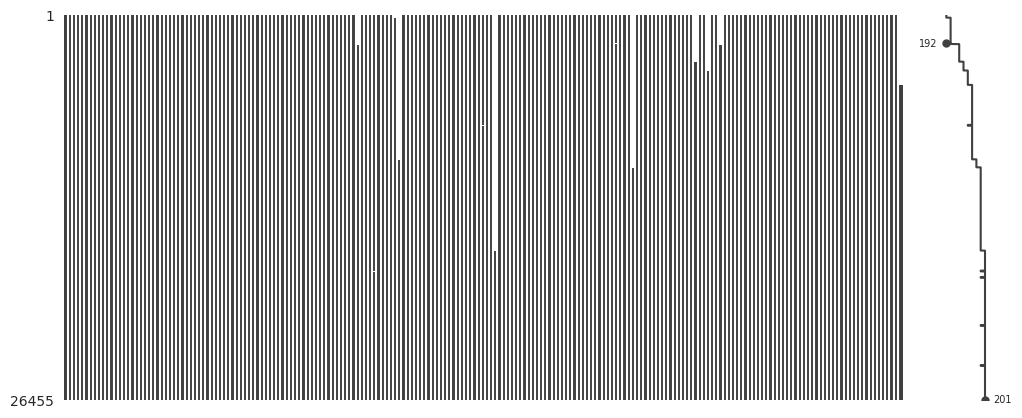

In [29]:
msno.matrix(ims, figsize=(12,5), fontsize=8);

* **Fill NaN Strategy**: A simple fill_forward is used:

In [30]:
train_reshaped.loc[:,"imbalance_size"].fillna(method="ffill",axis=0,inplace=True)

In [31]:
train_reshaped.loc[:,"imbalance_size"].isnull().sum()[train_reshaped.loc[:,"imbalance_size"].isnull().sum()>0]

stock_id
69      2035
78       220
79      9955
102    16225
135    10505
150     3245
153     3850
156     2035
199     4840
dtype: int64

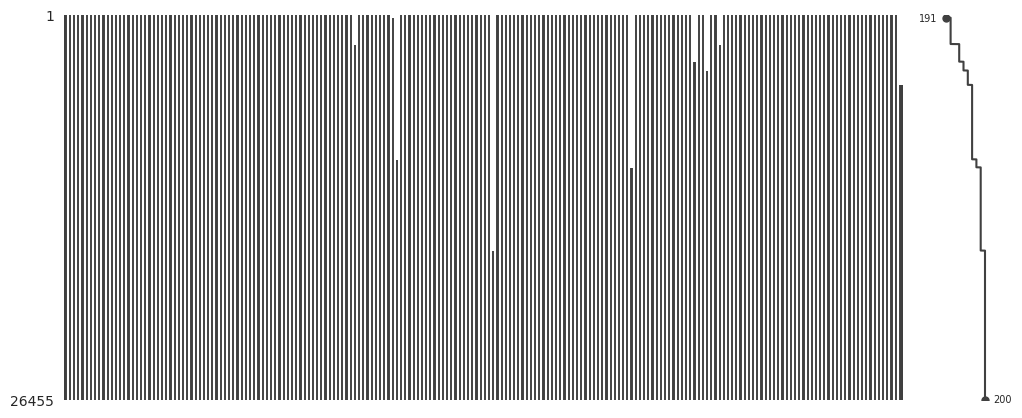

In [32]:
msno.matrix(train_reshaped.loc[:,"imbalance_size"], figsize=(12,5), fontsize=8);

In [33]:
train_reshaped.loc[:,"imbalance_size"].isna().sum().sum()

52910

In [34]:
new_train = train_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)
print("Original Shape preserved: {}".format(new_train.shape==train.shape))

Original Shape preserved: True


### **3.3 imbalance_buy_sell_flag**

In [35]:
train_col = train_col_def(new_train)
train_reshaped = new_train.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
train_reshaped.shape

(26455, 2800)

In [36]:
imbs = train_reshaped.loc[:,"imbalance_buy_sell_flag"]
imbs = imbs.reset_index(level=1)
imbs.isnull().sum().sum()

53108

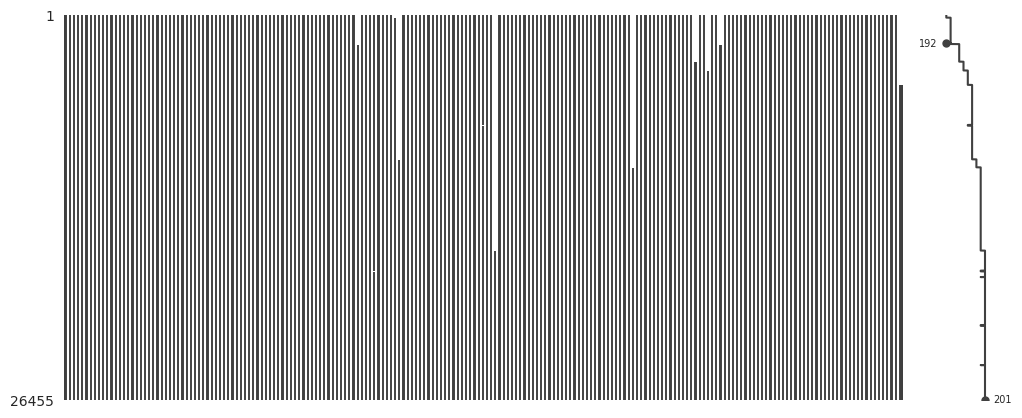

In [37]:
msno.matrix(imbs, figsize=(12,5), fontsize=8);

* **Fill NaN Strategy**: A simple fill_forward is used:

In [38]:
train_reshaped.loc[:,"imbalance_buy_sell_flag"].fillna(method="ffill",axis=0,inplace=True)

In [39]:
train_reshaped.loc[:,"imbalance_buy_sell_flag"].isna().sum().sum()

52910

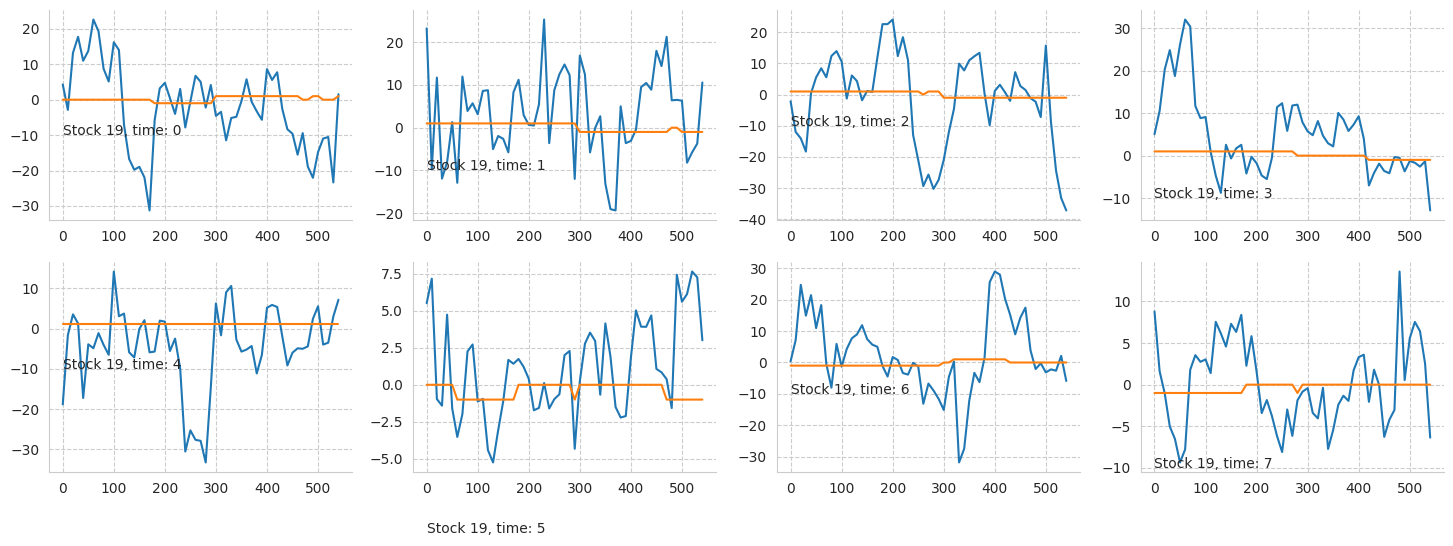

In [40]:
fig, axs = plt.subplots(2,4, figsize=(18,6))
axs=np.ravel(axs)

for i in range(8):

  axs[i].plot("seconds_in_bucket","target",data=train.query("stock_id == 19 & date_id == {}".format(i)))
  axs[i].plot("seconds_in_bucket","imbalance_buy_sell_flag",data=train.query("stock_id == 19 & date_id == {}".format(i)))
  axs[i].text(x=0, y=-10, s="Stock 19, time: {}".format(i), fontdict=None)

In [41]:
new_train = train_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)
print("Original Shape preserved: {}".format(new_train.shape==train.shape))

Original Shape preserved: True


#### 3.3.1 Create new Feature: "INBALANCE_SIZE_SIGN"

In [42]:
new_train["imbalance_size_sign"] = new_train["imbalance_size"].multiply(new_train["imbalance_buy_sell_flag"])
new_train.isna().sum()

time_id                      0
date_id                      0
stock_id                     0
seconds_in_bucket            0
imbalance_size               0
imbalance_buy_sell_flag      0
reference_price            132
matched_size               132
far_price                    0
near_price                   0
bid_price                  132
bid_size                     0
ask_price                  132
ask_size                     0
wap                        132
target                       0
check_near_far               0
imbalance_size_sign          0
dtype: int64

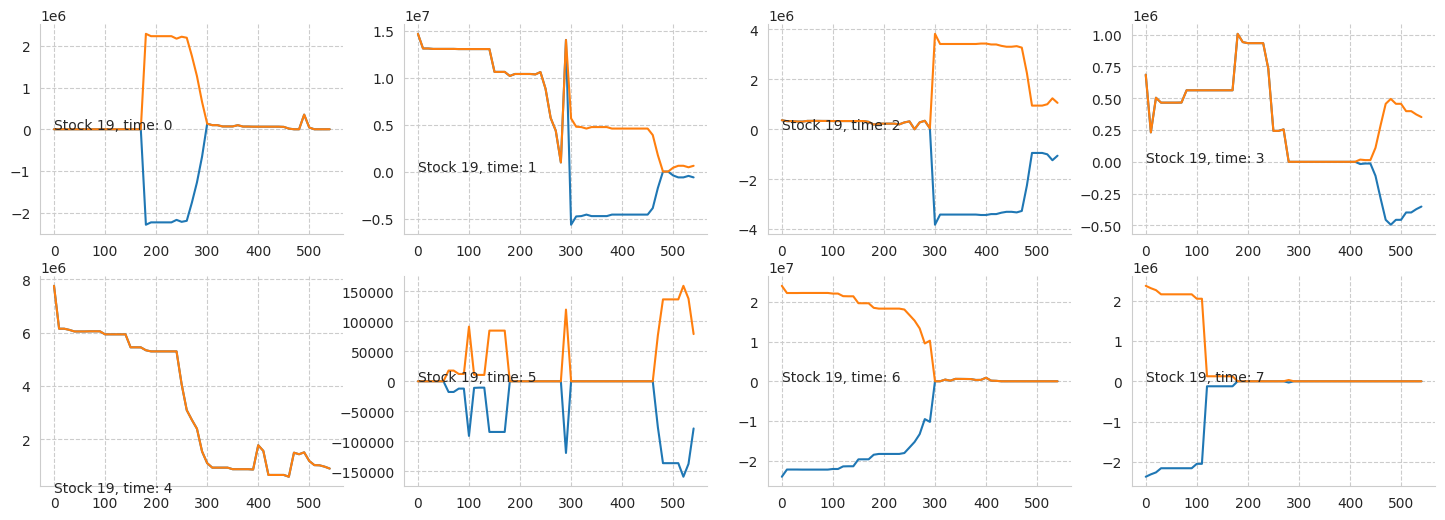

In [43]:
fig, axs = plt.subplots(2,4, figsize=(18,6))
axs=np.ravel(axs)

for i in range(8):

  #axs[i].plot("seconds_in_bucket","target",data=train.query("stock_id == 19 & date_id == {}".format(i)))
  axs[i].plot("seconds_in_bucket","imbalance_size_sign",data=new_train.query("stock_id == 19 & date_id == {}".format(i)))
  axs[i].plot("seconds_in_bucket","imbalance_size",data=new_train.query("stock_id == 19 & date_id == {}".format(i)))
  axs[i].text(x=0, y=-10, s="Stock 19, time: {}".format(i), fontdict=None)

#### 3.3.2 Create new Feature: "INBALANCE_SIZE_SIGN_DELTA"

In [44]:
new_train["imbalance_size_sign_delta"] = 0

train_col = train_col_def(new_train)
train_reshaped = new_train.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
train_reshaped.shape

(26455, 3200)

In [45]:
{a for a,b in train_reshaped.columns}

{'ask_price',
 'ask_size',
 'bid_price',
 'bid_size',
 'check_near_far',
 'far_price',
 'imbalance_buy_sell_flag',
 'imbalance_size',
 'imbalance_size_sign',
 'imbalance_size_sign_delta',
 'matched_size',
 'near_price',
 'reference_price',
 'seconds_in_bucket',
 'target',
 'wap'}

<Axes: >

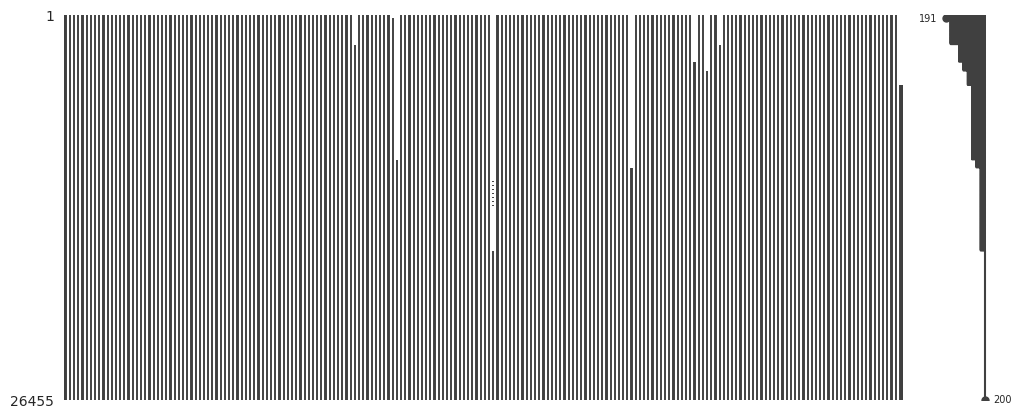

In [46]:
train_reshaped["imbalance_size_sign_delta"] = train_reshaped["imbalance_size_sign"].diff()
train_reshaped["imbalance_size_sign_delta"].fillna(method="ffill",inplace=True)
train_reshaped["imbalance_size_sign_delta"][train_reshaped[("seconds_in_bucket",0)]==0] = 0
msno.matrix(train_reshaped["imbalance_size_sign_delta"], figsize=(12,5), fontsize=8)

In [47]:
new_train = train_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)
new_train.shape

(5237892, 19)

In [48]:
new_train.isna().sum()

time_id                        0
date_id                        0
stock_id                       0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price              132
matched_size                 132
far_price                      0
near_price                     0
bid_price                    132
bid_size                       0
ask_price                    132
ask_size                       0
wap                          132
target                         0
check_near_far                 0
imbalance_size_sign            0
imbalance_size_sign_delta      0
dtype: int64

In [49]:
new_train[new_train.imbalance_size_sign_delta.isna()==True]

,time_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,check_near_far,imbalance_size_sign,imbalance_size_sign_delta


### **3.4 VAW**

In [50]:
train_col = train_col_def(new_train)
train_reshaped = new_train.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
train_reshaped.shape

(26455, 3200)

In [51]:
wap = train_reshaped.loc[:,"wap"]
wap = wap.reset_index(level=1)
wap.isnull().sum().sum()

53240

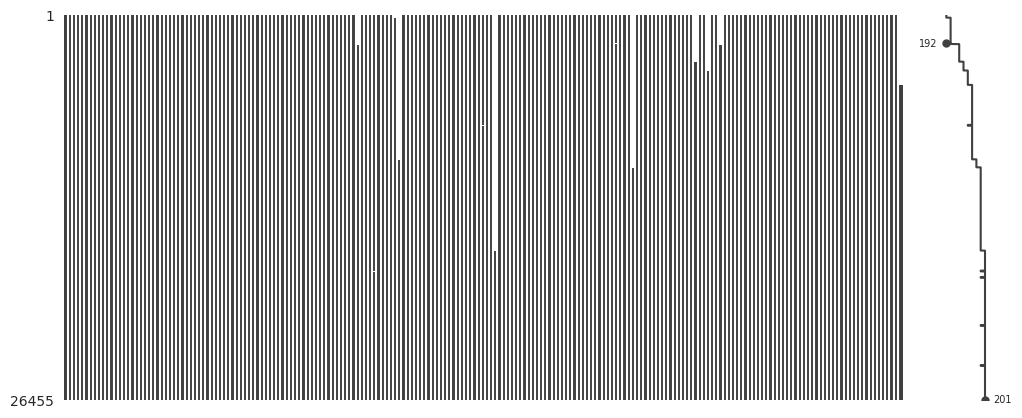

In [52]:
msno.matrix(wap, figsize=(12,5), fontsize=8);

* **NaN are filled with a "forward_filled"**

In [53]:
train_reshaped.loc[:,"wap"].fillna(method="ffill",inplace=True)

In [54]:
new_train = train_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)
new_train.shape

(5237892, 19)

In [55]:
new_train.isna().sum()

time_id                        0
date_id                        0
stock_id                       0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price              132
matched_size                 132
far_price                      0
near_price                     0
bid_price                    132
bid_size                       0
ask_price                    132
ask_size                       0
wap                            0
target                         0
check_near_far                 0
imbalance_size_sign            0
imbalance_size_sign_delta      0
dtype: int64

### **3.5 Reference_price**

In [56]:
train_col = train_col_def(new_train)
train_reshaped = new_train.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
train_reshaped.shape

(26455, 3200)

In [57]:
rp = train_reshaped.loc[:,"reference_price"]
rp = rp.reset_index(level=1)
rp.isnull().sum().sum()

53240

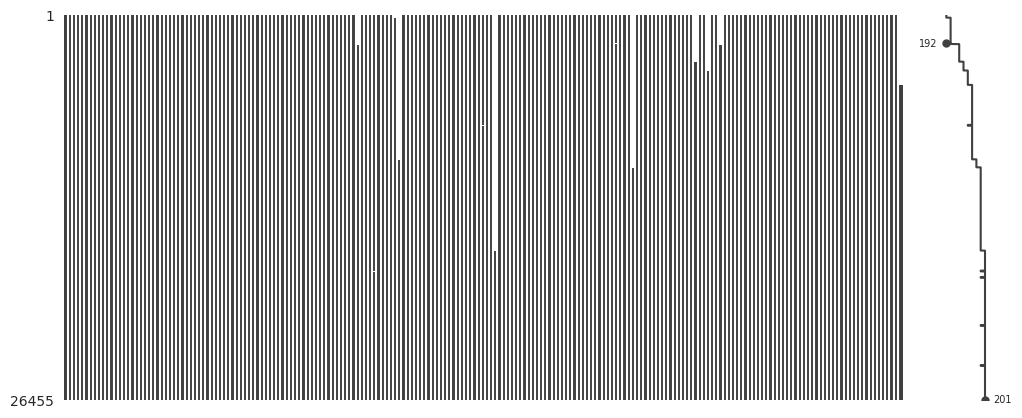

In [58]:
msno.matrix(rp, figsize=(12,5), fontsize=8);

* **NaN are filled with a "forward_filled"**

In [59]:
train_reshaped.loc[:,"reference_price"].fillna(method="ffill",inplace=True)

In [60]:
new_train = train_reshaped.stack(level=1).reset_index().dropna(axis=0, thresh=10)
new_train.shape

(5237892, 19)

In [61]:
new_train.isna().sum()

time_id                        0
date_id                        0
stock_id                       0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                 132
far_price                      0
near_price                     0
bid_price                    132
bid_size                       0
ask_price                    132
ask_size                       0
wap                            0
target                         0
check_near_far                 0
imbalance_size_sign            0
imbalance_size_sign_delta      0
dtype: int64

### 3.6 Matched_size - bid_price - ask_price

In [62]:
train_col = train_col_def(new_train)
train_reshaped = new_train.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
train_reshaped.shape

(26455, 3200)

In [63]:
rp = train_reshaped.loc[:,["matched_size","bid_price","ask_price"]]
rp = rp.reset_index(level=1)
rp.isnull().sum().sum()

159720

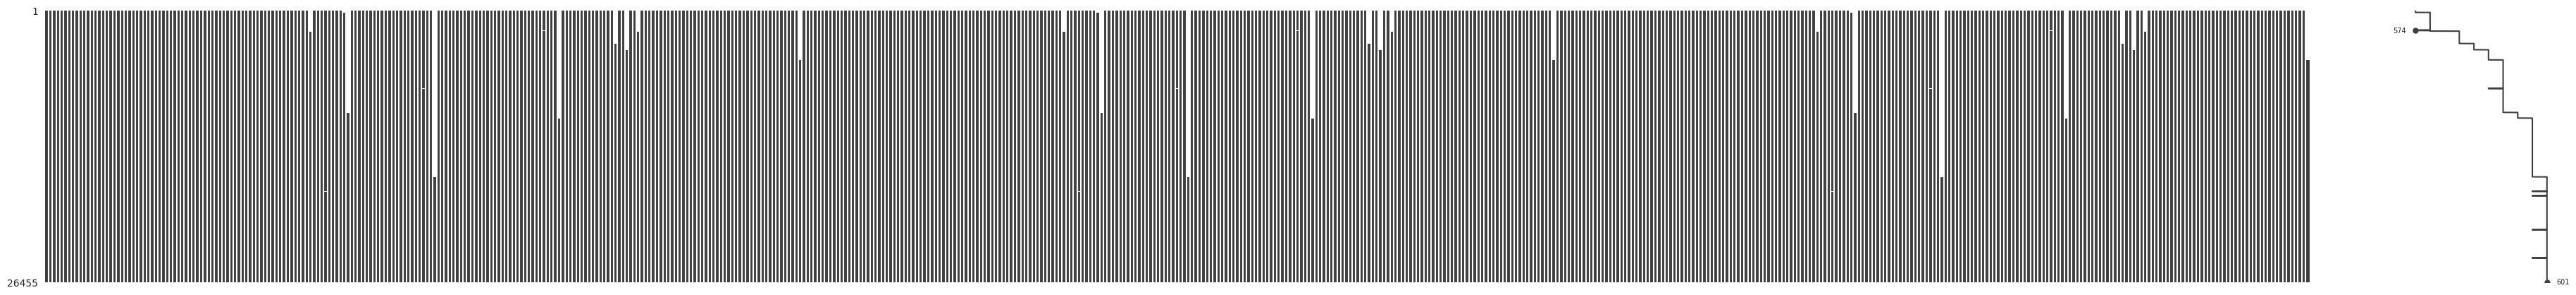

In [64]:
msno.matrix(rp, figsize=(46,5), fontsize=8);

* **NaN are filled with a "forward_filled"**

In [65]:
train_reshaped.loc[:,"matched_size"].fillna(method="ffill",inplace=True,axis=0)
train_reshaped.loc[:,"bid_price"].fillna(method="ffill",inplace=True,axis=0)
train_reshaped.loc[:,"ask_price"].fillna(method="ffill",inplace=True,axis=0)

In [66]:
new_train = train_reshaped.stack(level=1).reset_index(drop=False).dropna(axis=0, thresh=10)
new_train.reset_index(drop=True,inplace=True)
new_train.shape

(5237892, 19)

In [67]:
new_train.isna().sum()

time_id                      0
date_id                      0
stock_id                     0
seconds_in_bucket            0
imbalance_size               0
imbalance_buy_sell_flag      0
reference_price              0
matched_size                 0
far_price                    0
near_price                   0
bid_price                    0
bid_size                     0
ask_price                    0
ask_size                     0
wap                          0
target                       0
check_near_far               0
imbalance_size_sign          0
imbalance_size_sign_delta    0
dtype: int64

In [68]:
train_new_df.reset_index(drop=True,inplace=True)
train_new_df

,time_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,check_near_far,imbalance_size_sign,imbalance_size_sign_delta
0,0,0,0,0.0,3180602.69,1.0,0.999812,13380276.64,0.999891,0.999889,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.999998,3180602.69,0.00
1,0,0,1,0.0,166603.91,-1.0,0.999896,1642214.25,0.999891,0.999889,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.999998,-166603.91,0.00
2,0,0,2,0.0,302879.87,-1.0,0.999561,1819368.03,0.999891,0.999889,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.999998,-302879.87,0.00
3,0,0,3,0.0,11917682.27,-1.0,1.000171,18389745.62,0.999891,0.999889,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.999998,-11917682.27,0.00
4,0,0,4,0.0,447549.96,-1.0,0.999532,17860614.95,0.999891,0.999889,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.999998,-447549.96,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,26454,480,195,540.0,2440722.89,-1.0,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,1.000000,-2440722.89,0.00
5237888,26454,480,196,540.0,349510.47,-1.0,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,1.000257,-349510.47,0.00
5237889,26454,480,197,540.0,0.00,0.0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,1.000000,0.00,928672.32
5237890,26454,480,198,540.0,1000898.84,1.0,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,1.000000,1000898.84,0.00


## **5.0 Features Generation**

In [69]:
train_new_df.shape

(5237892, 19)

In [70]:
train_new_df

,time_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,check_near_far,imbalance_size_sign,imbalance_size_sign_delta
0,0,0,0,0.0,3180602.69,1.0,0.999812,13380276.64,0.999891,0.999889,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.999998,3180602.69,0.00
1,0,0,1,0.0,166603.91,-1.0,0.999896,1642214.25,0.999891,0.999889,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.999998,-166603.91,0.00
2,0,0,2,0.0,302879.87,-1.0,0.999561,1819368.03,0.999891,0.999889,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.999998,-302879.87,0.00
3,0,0,3,0.0,11917682.27,-1.0,1.000171,18389745.62,0.999891,0.999889,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.999998,-11917682.27,0.00
4,0,0,4,0.0,447549.96,-1.0,0.999532,17860614.95,0.999891,0.999889,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.999998,-447549.96,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,26454,480,195,540.0,2440722.89,-1.0,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,1.000000,-2440722.89,0.00
5237888,26454,480,196,540.0,349510.47,-1.0,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,1.000257,-349510.47,0.00
5237889,26454,480,197,540.0,0.00,0.0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,1.000000,0.00,928672.32
5237890,26454,480,198,540.0,1000898.84,1.0,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,1.000000,1000898.84,0.00


In [71]:
train_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237892 entries, 0 to 5237891
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   time_id                    int64  
 1   date_id                    int64  
 2   stock_id                   int64  
 3   seconds_in_bucket          float64
 4   imbalance_size             float64
 5   imbalance_buy_sell_flag    float64
 6   reference_price            float64
 7   matched_size               float64
 8   far_price                  float64
 9   near_price                 float64
 10  bid_price                  float64
 11  bid_size                   float64
 12  ask_price                  float64
 13  ask_size                   float64
 14  wap                        float64
 15  target                     float64
 16  check_near_far             float64
 17  imbalance_size_sign        float64
 18  imbalance_size_sign_delta  float64
dtypes: float64(16), int64(3)
memory usage: 759

In [72]:
train_col = train_col_def(train_new_df)
train_reshaped = train_new_df.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")

In [73]:
train_new_df_work = train_new_df.copy()
train_reshape_work = train_reshaped.copy()
train_reshape_work.shape

(26455, 3200)

In [74]:
revealed_targets

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0,481,0,26455,-1.279712,480,26400
1,1,481,0,26455,-4.460216,480,26400
2,2,481,0,26455,5.899668,480,26400


In [75]:
train_new_df_work[(train_new_df_work.stock_id==2)&(train_new_df_work.date_id==480)&(train_new_df_work.time_id==26400)]

,time_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,check_near_far,imbalance_size_sign,imbalance_size_sign_delta
5226894,26400,480,2,0.0,2668166.82,-1.0,1.000514,3178828.19,0.999891,0.999889,0.999999,194.02,1.000462,63279.86,1.0,5.899668,0.999998,-2668166.82,0.0


#### 5.1 Target Dispersion

In [76]:
train_new_df_work

,time_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,check_near_far,imbalance_size_sign,imbalance_size_sign_delta
0,0,0,0,0.0,3180602.69,1.0,0.999812,13380276.64,0.999891,0.999889,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0.999998,3180602.69,0.00
1,0,0,1,0.0,166603.91,-1.0,0.999896,1642214.25,0.999891,0.999889,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0.999998,-166603.91,0.00
2,0,0,2,0.0,302879.87,-1.0,0.999561,1819368.03,0.999891,0.999889,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0.999998,-302879.87,0.00
3,0,0,3,0.0,11917682.27,-1.0,1.000171,18389745.62,0.999891,0.999889,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0.999998,-11917682.27,0.00
4,0,0,4,0.0,447549.96,-1.0,0.999532,17860614.95,0.999891,0.999889,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0.999998,-447549.96,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,26454,480,195,540.0,2440722.89,-1.0,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,1.000000,-2440722.89,0.00
5237888,26454,480,196,540.0,349510.47,-1.0,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,1.000257,-349510.47,0.00
5237889,26454,480,197,540.0,0.00,0.0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,1.000000,0.00,928672.32
5237890,26454,480,198,540.0,1000898.84,1.0,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,1.000000,1000898.84,0.00


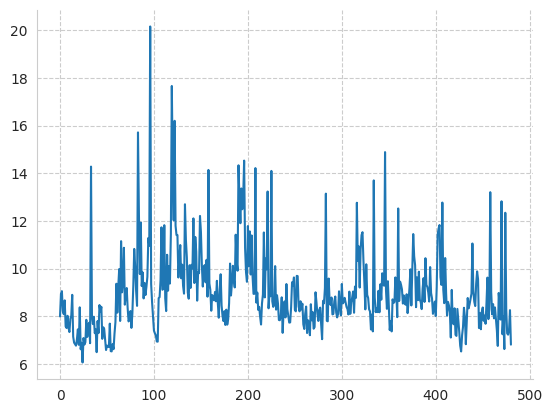

In [77]:
train_reshape_work["dispersion"] = train_reshape_work["target"].std(axis=1)
train_reshape_work

tot_daily_dispersion=train_reshape_work.reset_index().groupby("date_id", as_index=False)["dispersion"].agg("mean")
tot_daily_dispersion["dispersion"].plot()

acorr = sm.tsa.acf(tot_daily_dispersion["dispersion"].dropna(), nlags = 60)
pacorr = sm.tsa.pacf(tot_daily_dispersion["dispersion"].dropna(), nlags = 60)

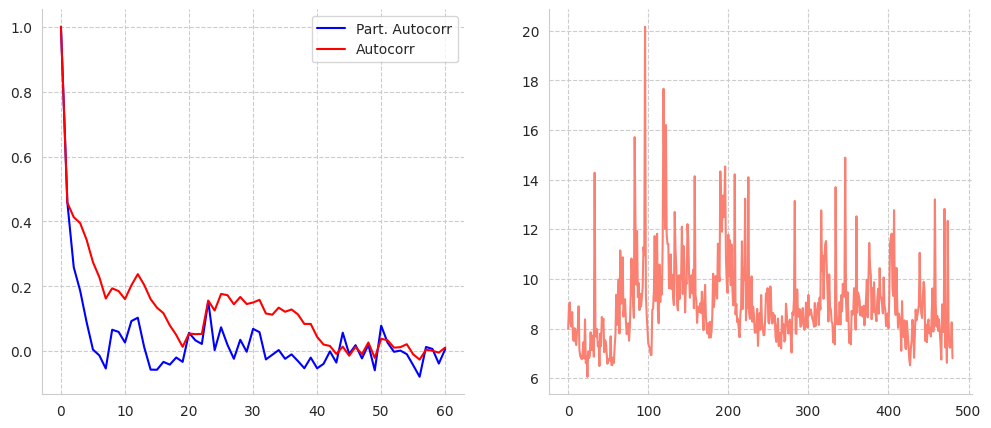

In [78]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(pacorr,c="blue",label="Part. Autocorr");
ax[0].plot(acorr,c="red",label="Autocorr");

ax[0].legend()

ax[1].plot(tot_daily_dispersion["dispersion"], color="salmon")

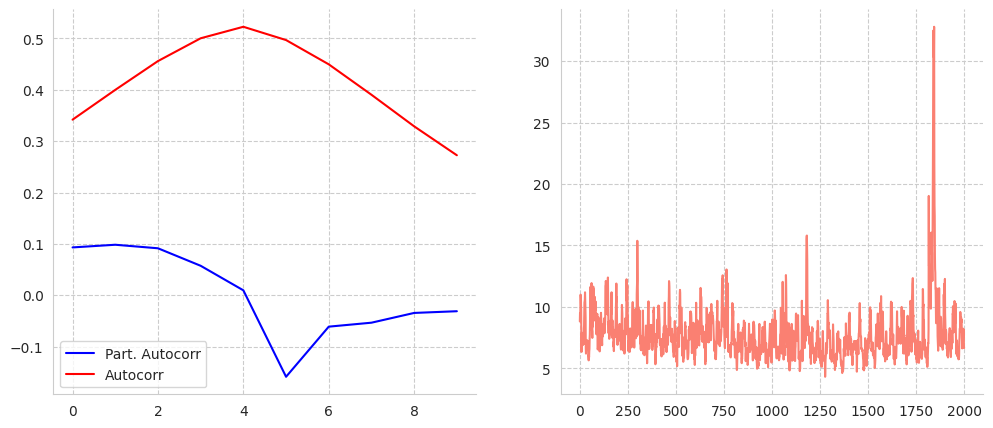

In [79]:
acorr = sm.tsa.acf(train_reshape_work["dispersion"].dropna(), nlags = 60)
pacorr = sm.tsa.pacf(train_reshape_work["dispersion"].dropna(), nlags = 60)

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(pacorr[-10:],c="blue",label="Part. Autocorr");
ax[0].plot(acorr[-10:],c="red",label="Autocorr");

ax[0].legend()

ax[1].plot(train_reshape_work["dispersion"].values[:2000], color="salmon")

In [80]:
pd.merge(left=train_reshape_work.reset_index(), right=tot_daily_dispersion, left_on="date_id", right_on="date_id",)

time_id date_id seconds_in_bucket                                     \
stock_id                                 0      1      2      3      4      5   
0              0       0               0.0    0.0    0.0    0.0    0.0    0.0   
1              1       0              10.0   10.0   10.0   10.0   10.0   10.0   
2              2       0              20.0   20.0   20.0   20.0   20.0   20.0   
3              3       0              30.0   30.0   30.0   30.0   30.0   30.0   
4              4       0              40.0   40.0   40.0   40.0   40.0   40.0   
...          ...     ...               ...    ...    ...    ...    ...    ...   
26450      26450     480             500.0  500.0  500.0  500.0  500.0  500.0   
26451      26451     480             510.0  510.0  510.0  510.0  510.0  510.0   
26452      26452     480             520.0  520.0  520.0  520.0  520.0  520.0   
26453      26453     480             530.0  530.0  530.0  530.0  530.0  530.0   
26454      26454     480             540.0  540.0  540.0  540.0  540.0  540.0   

                        ... imbalance_size_sign_delta                         \
stock_id      6      7  ...                       192         193        194   
0           0.0    0.0  ...                      0.00        0.00       0.00   
1          10.0   10.0  ...                -287536.13  3219385.36  -44951.28   
2          20.0   20.0  ...                 -15340.50   368239.20       0.00   
3          30.0   30.0  ...                      0.00  -747579.73       0.00   
4          40.0   40.0  ...                 -24256.36  -494144.52   14281.04   
...         ...    ...  ...                       ...         ...        ...   
26450     500.0  500.0  ...                      0.00  -568604.26   24570.57   
26451     510.0  510.0  ...                   6771.54   230275.44 -108487.78   
26452     520.0  520.0  ...                      0.00  -215900.42    2418.36   
26453     530.0  530.0  ...                 -22802.12   -23316.42       0.00   
26454     540.0  540.0  ...                  -6771.54   -55230.34  108487.79   

                                                                   \
stock_id        195        196        197         198         199   
0              0.00       0.00       0.00        0.00         NaN   
1        -932293.99       0.00    2267.73 -1752892.97         NaN   
2              0.00       0.00       0.00        0.00         NaN   
3          76695.97       0.00       0.00   -26479.28         NaN   
4         -95715.16       0.00       0.00  -472476.79         NaN   
...             ...        ...        ...         ...         ...   
26450      16981.03 -341303.63       0.00        0.00 -1144044.10   
26451    -584730.62      38.90   75664.06        0.00     2865.85   
26452      83275.66       0.00   30628.47        0.00  1306358.73   
26453      15437.30       0.00   49304.37  1000898.84        0.00   
26454          0.00       0.00  928672.32        0.00  -531726.83   

         dispersion_x dispersion_y  
stock_id                            
0            8.817410     7.989285  
1            9.499834     7.989285  
2            9.167147     7.989285  
3           10.046180     7.989285  
4           10.998737     7.989285  
...               ...          ...  
26450        5.078323     6.805624  
26451        5.330722     6.805624  
26452        5.570038     6.805624  
26453        5.526282     6.805624  
26454        6.360306     6.805624  

[26455 rows x 3204 columns]

#### **5.x Function to Create new Features**

In [81]:
def create_new_features(df):
  df_=df.copy()
  train_col = train_col_def(df_)
  try:
    train_col.remove("dispersion")
  except:
    pass
  df_resh_ = train_new_df.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")
  # Add return dispersion
  df_resh_["dispersion"] = df_resh_["target"].std(axis=1)
  daily_dispersion=df_resh_.groupby(["date_id"])["dispersion"].agg("mean")
  df_resh_.drop("dispersion",axis=1,inplace=True)


  new_df = df_resh_.stack(level=1).reset_index(drop=False).dropna(axis=0, thresh=10)
  new_df = pd.merge(left=new_df, right=daily_dispersion, left_on="date_id", right_on="date_id",)

  # Add bid-ask spread
  new_df["bid_ask_spread"] = new_df["ask_price"]-new_df["bid_price"]

  # Add bid-ask_size_spread
  new_df["bid_ask_size_spread"] = new_df["ask_size"]-new_df["bid_size"]

  # Add mid_price
  new_df["mid_price"] = new_df[["ask_price","bid_price"]].mean(axis=1)

  train_col = train_col_def(new_df)
  df_resh_ = new_df.groupby(["stock_id","time_id","date_id"])[train_col].agg("first").unstack("stock_id")

  df_resh_["dispersion"] = df_resh_["dispersion"].shift(55)
  df_resh_["dispersion"].fillna(df_resh_["dispersion"].median(),inplace=True)

  #reshape to original shape
  new_df = df_resh_.stack(level=1).reset_index(drop=False).dropna(axis=0, thresh=10)

  return df_resh_ , new_df

df_resh_exp, df_exp = create_new_features(train_new_df)

In [171]:
%time
test_ts = df_resh_exp.copy()
to_merge = test_ts.loc[:,["wap"]]
to_merge_price = test_ts.loc[:,["wap"]]/10_000+1

#display(to_merge_price.head(3))

to_merge.rename({"wap":"rsi"},axis=1,inplace=True)
to_merge_price.rename({"wap":"cum_price"},axis=1,inplace=True)

#display(to_merge_price.head(3))

to_merge.fillna(0,inplace=True)
to_merge_price.fillna(1,inplace=True)

#display(to_merge_price.head(3))

to_merge_price_ = to_merge_price.cumprod()

#display(to_merge_price.head(3))

for i_ in tqdm(range(5)):
  rsi = get_rsi(to_merge_price_.loc[:,("cum_price",i_)], 14)
  to_merge.loc[:,("rsi",i_)] = rsi

to_merge.fillna(method="ffill",inplace=True)
to_merge.fillna(method="bfill",inplace=True)

mask = test_ts.loc[:,["wap"]].isna()==False
mask.astype("float").replace({0:np.nan},inplace=True)
to_merge = to_merge*mask.values

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


In [ ]:
to_merge.loc[:200,("rsi",2)].plot()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'target_rsi'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas/_libs/index.pyx", line 774, in pandas._libs.index.BaseMultiIndexCodesEngine.get_loc
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3804, in get_loc
    raise KeyError(key) from err
KeyError: 'target_rsi'

During handling of the above exception

<Axes: xlabel='time_id,date_id'>

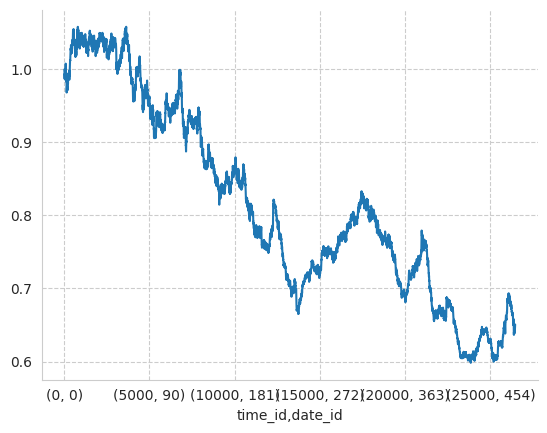

In [114]:
to_merge.fillna(0,inplace=True)
to_merge_price.fillna(1,inplace=True)
to_merge_price.rename({"target":"cum_price"},axis=1,inplace=True)
to_merge_price = to_merge_price.cumprod()


to_merge_price.loc[:,("cum_price",8)].plot()

In [167]:
to_merge

target_rsi                                              \
stock_id                0          1          2          3          4     
time_id date_id                                                           
0       0        100.000000   0.000000   0.000000   0.000000   0.000000   
1       0        100.000000   0.000000   0.000000   0.000000   0.000000   
2       0        100.000000   0.000000   0.000000   0.000000   0.000000   
3       0        100.000000   0.000000   0.000000  28.882909   0.000000   
4       0        100.000000   0.000000   0.000000  17.537331   0.000000   
...                     ...        ...        ...        ...        ...   
26450   480       81.024583  17.450106  24.932406  37.069927  53.002689   
26451   480       82.646579  20.754461  21.521490  43.718848  56.388191   
26452   480       82.243295  26.447730  18.868006  50.521748  58.865179   
26453   480       83.801738  35.756687  16.683316  55.853518  59.315431   
26454   480       84.167785  46.605552  16.090229  58.747907  60.865965   

                                                                         ...  \
stock_id                5          6          7          8          9    ...   
time_id date_id                                                          ...   
0       0        100.000000   0.000000   0.000000   0.000000   0.000000  ...   
1       0        100.000000   0.000000   0.000000   0.000000   0.000000  ...   
2       0        100.000000  42.427126   0.000000   0.000000   0.000000  ...   
3       0         96.815271  47.054166   0.000000   0.000000   0.000000  ...   
4       0         94.641350  60.481583   0.000000   0.000000   0.000000  ...   
...                     ...        ...        ...        ...        ...  ...   
26450   480       37.903175  47.786046  35.571184  87.970490  82.993429  ...   
26451   480       39.305248  47.516060  32.893410  88.338587  83.581737  ...   
26452   480       41.104546  46.726244  29.545700  89.084478  83.708398  ...   
26453   480       39.879317  45.759783  28.638321  89.517198  83.793129  ...   
26454   480       42.024071  47.165897  27.755548  90.002131  80.501588  ...   

                                                                          \
stock_id                190         191        192        193        194   
time_id date_id                                                            
0       0        100.000000  100.000000   0.000000   0.000000   0.000000   
1       0        100.000000  100.000000   0.000000   0.000000   0.000000   
2       0        100.000000   84.985143   0.000000  57.064010   0.000000   
3       0         94.461586   85.495768   0.000000  80.157748   0.000000   
4       0         91.122071   83.222782   0.000000  89.023186   0.000000   
...                     ...         ...        ...        ...        ...   
26450   480       24.752034   22.772422  66.055254  84.941635  63.351806   
26451   480       23.011750   22.020109  67.265715  83.464808  64.322598   
26452   480       22.231050   21.733593  67.011792  80.738103  66.236993   
26453   480       21.501193   21.663045  63.127418  78.799233  67.504489   
26454   480       21.255803   22.386892  60.068803  73.347968  69.428443   

                                                                        
stock_id               195        196        197        198        199  
time_id date_id                                                         
0       0         0.000000   0.000000   0.000000   0.000000   0.000000  
1       0         0.000000   0.000000   0.000000   0.000000   0.000000  
2       0        82.770354   0.000000   0.000000  66.350569   0.000000  
3       0        91.648343  35.308828  14.283638  81.586794   0.000000  
4       0        93.840786  26.521935  12.149485  89.518126   0.000000  
...                    ...        ...        ...        ...        ...  
26450   480      81.507681  75.575712  22.491647  43.947224  78.629860  
26451   480      83.598710  71.584818  20.997440  

In [170]:
to_merge_price_

cum_price                                                    \
stock_id              0         1         2         3         4         5     
time_id date_id                                                               
0       0        0.999697  0.999448  0.999161  0.999599  0.999265  1.000678   
1       0        0.999736  0.999286  0.998416  0.999495  0.998594  1.001450   
2       0        1.000158  0.998641  0.997779  0.999292  0.998525  1.001551   
3       0        1.000703  0.998126  0.997198  0.999405  0.998266  1.001241   
4       0        1.001020  0.997453  0.997170  0.999170  0.997777  1.001034   
...                   ...       ...       ...       ...       ...       ...   
26450   480      0.498554  0.712871  1.053346  0.690373  0.550179  0.967660   
26451   480      0.498713  0.713097  1.052760  0.690695  0.550297  0.967822   
26452   480      0.498705  0.713503  1.052201  0.691084  0.550388  0.968026   
26453   480      0.498860  0.714263  1.051650  0.691446  0.550404  0.967830   
26454   480      0.498898  0.715396  1.051487  0.691664  0.550460  0.968056   

                                                         ...            \
stock_id              6         7         8         9    ...       190   
time_id date_id                                          ...             
0       0        0.999750  0.999804  0.999403  1.000797  ...  1.000637   
1       0        0.999322  0.999003  0.999325  1.000733  ...  1.001058   
2       0        0.999615  0.997797  0.998913  1.000408  ...  1.001597   
3       0        0.999671  0.997108  0.998804  0.999731  ...  1.001269   
4       0        0.999891  0.996987  0.998495  0.998912  ...  1.001068   
...                   ...       ...       ...       ...  ...       ...   
26450   480      1.134086  1.519219  0.649751  0.606687  ...  1.204960   
26451   480      1.134045  1.518726  0.649921  0.606789  ...  1.204557   
26452   480      1.133931  1.518038  0.650273  0.606811  ...  1.204371   
26453   480      1.133797  1.517840  0.650483  0.606824  ...  1.204197   
26454   480      1.133957  1.517648  0.650723  0.606726  ...  1.204141   

                                                                             \
stock_id              191       192       193       194       195       196   
time_id date_id                                                               
0       0        1.001194  0.998847  0.999351  1.000400  0.999931  0.999919   
1       0        1.001454  0.997289  0.999176  0.999497  0.999799  0.999593   
2       0        1.000856  0.996021  0.999392  0.998497  1.000388  0.999590   
3       0        1.000987  0.994362  0.999801  0.997564  1.001090  0.999745   
4       0        1.000890  0.993444  1.000371  0.996418  1.001541  0.999610   
...                   ...       ...       ...       ...       ...       ...   
26450   480      2.929280  1.569942  1.471354  0.905622  0.499149  1.265888   
26451   480      2.928260  1.570165  1.471196  0.905832  0.499337  1.265503   
26452   480      2.927883  1.570143  1.470913  0.906250  0.499409  1.264703   
26453   480      2.927795  1.569810  1.470714  0.906532  0.499610  1.263774   
26454   480      2.928029  1.569539  1.470143  0.906970  0.499725  1.262735   

                                               
stock_id              197       198       199  
time_id date_id                                
0       0        0.999156  0.999949  1.000000  
1       0        0.998715  0.999807  1.000000  
2       0        0.998034  1.000067  1.000000  
3       0        0.998203  1.000368  1.000000  
4       0        0.998010  1.000835  1.000000  
...                   ...       ...       ...  
26450   480      1.386345  0.422847  1.320539  
26451   480      1.385888  0.422760  1.319251  
26452   480      1.385611  0.422665  1.319730  
26453   480      1.385159  0.422531  1.320358  
26454   480      1.385321  0.422466  1.319496  

[26455 rows x 200 columns]

In [156]:
mask = test_ts.loc[:,["target"]].isna()==False
mask=mask.astype("float").replace({0:np.nan})
to_merge*mask.values


target_rsi                                           \
stock_id                0          1         2         3         4     
time_id date_id                                                        
0       0               NaN        NaN -8.389950 -4.010200 -7.349849   
1       0        100.000000   0.000000 -7.460117 -1.040101 -6.719828   
2       0        100.000000   0.000000 -6.380081 -2.030134 -0.690222   
3       0        100.000000   0.000000 -5.819797  1.130104 -2.589822   
4       0        100.000000   0.000000 -0.280142 -2.350211 -4.900098   
...                     ...        ...       ...       ...       ...   
26450   480       81.024583  17.450106 -4.450083  1.720190  1.939535   
26451   480       82.646579  20.754461 -5.559921  4.669428  2.139807   
26452   480       82.243295  26.447730 -5.310178  5.639792  1.660585   
26453   480       83.801738  35.756687 -5.239844  5.229711  0.300407   
26454   480       84.167785  46.605552 -1.549721  3.160238  1.009703   

                                                                    ...  \
stock_id              5         6          7         8         9    ...   
time_id date_id                                                     ...   
0       0        6.779432 -2.499819  -1.959801 -5.970001  7.970333  ...   
1       0        7.710457 -4.280209  -8.010268 -0.780225 -0.640154  ...   
2       0        1.009703  2.930164 -12.069941 -4.119873 -3.250241  ...   
3       0       -3.089905  0.560284  -6.909967 -1.090169 -6.759763  ...   
4       0       -2.070069  2.199411  -1.209974 -3.100038 -8.199811  ...   
...                   ...       ...        ...       ...       ...  ...   
26450   480     -4.569888 -0.630021  -1.729727 -0.680089  3.540516  ...   
26451   480      1.679659 -0.360012  -3.240108  2.609491  1.679659  ...   
26452   480      2.110004 -1.000166  -4.529953  5.409718  0.350475  ...   
26453   480     -2.030134 -1.180172  -1.310110  3.240108  0.220537  ...   
26454   480      2.340078  1.410246  -1.260042  3.679991 -1.609922  ...   

                                                                      \
stock_id              190        191        192       193        194   
time_id date_id                                                        
0       0        6.370544  11.940002 -11.529922 -6.489754   3.999472   
1       0        4.210472   2.599955 -15.599728 -1.749992  -9.030104   
2       0        5.379915  -5.970001 -12.710094  2.160072  -9.999871   
3       0       -3.269911   1.300573 -16.660095  4.090071  -9.340048   
4       0       -2.009869  -0.969768  -9.229779  5.700588 -11.489987   
...                   ...        ...        ...       ...        ...   
26450   480     -4.730225  -7.420182   2.959967 -2.359748  -0.650287   
26451   480     -3.340244  -3.479719   1.419783 -1.069903   2.319813   
26452   480     -1.549721  -1.289845  -0.140071 -1.929998   4.609823   
26453   480     -1.440048  -0.299811  -2.120137 -1.350045   3.110170   
26454   480     -0.470281   0.799894  -1.729727 -3.880262   4.839897   

                                                                   
stock_id              195       196       197       198       199  
time_id date_id                                                    
0       0       -0.690222 -0.810027 -8.440018 -0.510216       NaN  
1       0       -1.320243 -3.259778 -4.410148 -1.419783       NaN  
2       0        5.890131 -0.029802 -6.819964  2.599955       NaN  
3       0        7.020235  1.549721  1.690388  3.010035       NaN  
4       0        4.500151 -1.350045 -1.929998  4.669428       NaN  
...                   ...       ...       ...       ...       ...  
26450   480      3.190041 -1.659989 -0.690222 -2.700090 -7.209778  
26451   480      3.770590 -3.039837 -3.299713 -2.070069 -9.750128  
26452   480      1.449585 -6.319881 -1.999736 -2.239943  3.629923  
26453   480      4.019737 -7.349849 -3.259778 -3.160238  4.760027  
26454   480      2.310276 -8.220077  1.169443 -1.540184 -6.53028

In [84]:
pd.concat([test_ts,to_merge], axis=1)

ask_price                                                    \
stock_id              0         1         2         3         4         5     
time_id date_id                                                               
0       0        1.000026  1.000660  1.000298  1.000214  1.000016  1.000635   
1       0        1.000026  1.000660  1.000298  1.000042  1.000431  1.001898   
2       0        0.999919  1.000660  0.999877  1.000128  1.000154  1.001246   
3       0        1.000133  1.000308  0.999877  1.000042  1.000085  1.002020   
4       0        1.000455  1.000308  0.999930  1.000343  1.000085  1.001980   
...                   ...       ...       ...       ...       ...       ...   
26450   480      0.999193  0.996859  0.998865  0.999258  0.998700  0.998687   
26451   480      0.999017  0.997122  0.998865  0.999355  0.998755  0.998545   
26452   480      0.999368  0.997122  0.998813  0.999209  0.998755  0.998687   
26453   480      0.999368  0.997122  0.998555  0.999209  0.998809  0.998829   
26454   480      0.999368  0.997122  0.998555  0.999209  0.998809  0.998403   

                                                         ... target_rsi  \
stock_id              6         7         8         9    ...        190   
time_id date_id                                          ...              
0       0        1.000283  1.000130  1.000041  1.000646  ...   6.370544   
1       0        1.000388  1.000986  1.000267  1.001453  ...   4.210472   
2       0        1.000367  1.001157  1.000022  1.001776  ...   5.379915   
3       0        1.000388  1.000690  1.000377  1.001614  ...  -3.269911   
4       0        1.000388  1.000690  1.000257  1.001776  ...  -2.009869   
...                   ...       ...       ...       ...  ...        ...   
26450   480      1.000495  0.997017  1.001118  1.000879  ...  -4.730225   
26451   480      1.000469  0.996938  1.001103  1.001011  ...  -3.340244   
26452   480      1.000172  0.996874  1.001066  1.001143  ...  -1.549721   
26453   480      1.000442  0.996953  1.001066  1.001143  ...  -1.440048   
26454   480      1.000415  0.996858  1.001051  1.001143  ...  -0.470281   

                                                                      \
stock_id               191        192       193        194       195   
time_id date_id                                                        
0       0        11.940002 -11.529922 -6.489754   3.999472 -0.690222   
1       0         2.599955 -15.599728 -1.749992  -9.030104 -1.320243   
2       0        -5.970001 -12.710094  2.160072  -9.999871  5.890131   
3       0         1.300573 -16.660095  4.090071  -9.340048  7.020235   
4       0        -0.969768  -9.229779  5.700588 -11.489987  4.500151   
...                    ...        ...       ...        ...       ...   
26450   480      -7.420182   2.959967 -2.359748  -0.650287  3.190041   
26451   480      -3.479719   1.419783 -1.069903   2.319813  3.770590   
26452   480      -1.289845  -0.140071 -1.929998   4.609823  1.449585   
26453   480      -0.299811  -2.120137 -1.350045   3.110170  4.019737   
26454   480       0.799894  -1.729727 -3.880262   4.839897  2.310276   

                                                         
stock_id              196       197       198       199  
time_id date_id                                          
0       0       -0.810027 -8.440018 -0.510216       NaN  
1       0       -3.259778 -4.410148 -1.419783       NaN  
2       0       -0.029802 -6.819964  2.599955       NaN  
3       0        1.549721  1.690388  3.010035       NaN  
4       0       -1.350045 -1.929998  4.669428       NaN  
...                   ...       ...       ...       ...  
26450   480     -1.659989 -0.690222 -2.700090 -7.209778  
26451   480     -3.039837 -3.299713 -2.070069 -9.750128  
26452   480     -6.319881 -1.999736 -2.239943  3.629923  
26453   480     -7.349849 -3.259778 -3.160238  4.760027  
26454   480     -8.220077  1.169443 -1.540184 -6.530285  

[26455 rows x 4200 columns]

NameError: ignored

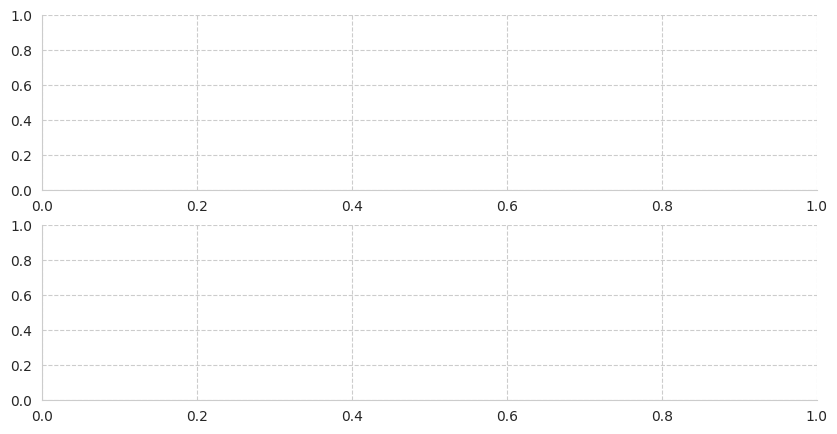

In [85]:
fig, axs = plt.subplots(2,1,figsize=(10,5))

cum_price[:400].plot(ax=axs[0])
rsi_price[:400].plot(ax=axs[1])

In [ ]:
df_resh_exp["target"]

In [ ]:
ret = cum_price.diff()
up = []
down = []
for i in range(len(ret)):
    if ret[i] < 0:
        up.append(0)
        down.append(ret[i])
    else:
        up.append(ret[i])
        down.append(0)
up_series = pd.Series(up)
down_series = pd.Series(down).abs()
up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
rs = up_ewm/down_ewm
rsi = 100 - (100 / (1 + rs))
rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
rsi_df = rsi_df.dropna()

In [ ]:
df_resh_exp.loc[:,"bid_price"].shape,df_resh_exp.loc[:,"ask_price"].shape

In [ ]:
gc.collect()


In [ ]:
fig, axs=plt.subplots(4,1,figsize=(16,5))
df_resh_exp["far_price"][0].plot(ax=axs[2],label="Far Price");
df_resh_exp["bid_ask_size_spread"][1].plot(ax=axs[1]);
df_resh_exp["imbalance_size_sign"][1].plot(ax=axs[0]);
df_resh_exp["reference_price"][1].plot(ax=axs[3]);
plt.tight_layout()

In [ ]:
corr = df_exp.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.grid(linestyle='')

In [ ]:
df_exp.columns
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(df_exp["bid_price"], color="salmon")
axs[1].scatter(df_exp["dispersion"],df_exp["target"])

In [ ]:
df_exp

# **VERIFY IF MEDIAN, STD, OR MEAN OF TARGET HAS PERSISTANCE OVER TIME**

In [ ]:
train_new_df

In [ ]:
price_session = train_new_df.groupby(["stock_id","date_id","time_id"])["target"].agg("first").unstack("stock_id")

In [ ]:
price_session

In [ ]:
plt.plot(price_session.iloc[:,5])

In [ ]:
price_session.fillna(method="ffill",inplace=True)
price_session.isnull().sum().sum()

In [ ]:
import statsmodels.api as sm
lags = range(5)

results_pacf = []

for sec in range(200):

  acorr = sm.tsa.acf(price_session.loc[:,sec].dropna(), nlags = len(lags)-1)
  pacorr = sm.tsa.pacf(price_session.loc[:,sec].dropna(), nlags = len(lags)-1)

  results_pacf.append(pacorr[1])
#plt.plot(acorr[:])
plt.plot(results_pacf,c="red");
print(np.array(results_pacf).mean())

In [ ]:
train.shape

In [ ]:
new_train.columns

In [ ]:
train.columns

In [ ]:
imbsd = train_reshaped.loc[:,"imbalance_buy_sell_flag"]
imbsd = imbsd.reset_index(level=1)
imbsd.isnull().sum().sum()

**TO DO: INBALANCE_SIZE_SIGN CHANGE**

In [ ]:
g = sns.relplot(
    data=new_train.query("date_id == 0 & stock_id < 8"),
    x="seconds_in_bucket",
    y="target",
    kind="line",
    col="stock_id",
    col_wrap=4
)
for stock_id, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(0.1, .85, f"Stock {stock_id}", transform=ax.transAxes, fontweight="bold")
g.set_titles("")
g.refline(y=0)
g.tight_layout()
plt.show()

In [ ]:
g = sns.relplot(
    data=new_train.query("stock_id == 0 & date_id < 8"),
    x="seconds_in_bucket",
    y="target",
    kind="line",
    col="date_id",
    col_wrap=4
)
g.refline(y=0)
for date_id, ax in g.axes_dict.items():
    ax.text(.8, .85, f"date_id = {date_id}", transform=ax.transAxes, fontweight="bold")
g.set_titles("")
g.tight_layout()
plt.show()

In [ ]:
price_session = new_train.groupby(["stock_id","time_id","date_id"])["target"].agg("first").unstack("stock_id")
price_session = price_session.reset_index(level=1)
price_session.isnull().sum().sum()

In [ ]:
price_session.loc[price_session["date_id"]==0,0].plot()
price_session.loc[price_session["date_id"]==0,1].plot()
plt.grid(linestyle="--")

In [ ]:
corr = price_session.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=0.0, cbar_kws={"shrink": .5})
plt.grid(linestyle='')

In [ ]:
msno.heatmap(price_session, figsize=(10,6), fontsize=8)

In [ ]:
msno.matrix(price_session)

In [ ]:
imb_size = train.groupby(["stock_id","time_id","date_id"])["imbalance_size"].agg("first").unstack("stock_id")
imb_size = imb_size.reset_index(level=1)
imb_size.isnull().sum().sum()

In [ ]:
msno.matrix(imb_size)

In [ ]:
imb_size.isnull().sum().sum()-price_session.isnull().sum().sum()

In [ ]:
price_session.fillna(method="ffill",inplace=True)
price_session.isnull().sum().sum()

In [ ]:
import statsmodels.api as sm
lags = range(55)
acorr = sm.tsa.acf(price_session.loc[:,2], nlags = len(lags)-1)
pacorr = sm.tsa.pacf(price_session.loc[:,2], nlags = len(lags)-1)
plt.plot(acorr[1:])
plt.plot(pacorr[1:],c="red")

In [ ]:
pacorr[1:]